In [1]:
%matplotlib inline

# Install required libraries
!pip install gym numpy networkx matplotlib


In [2]:
# Import libraries
import gym
from gym import spaces
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output


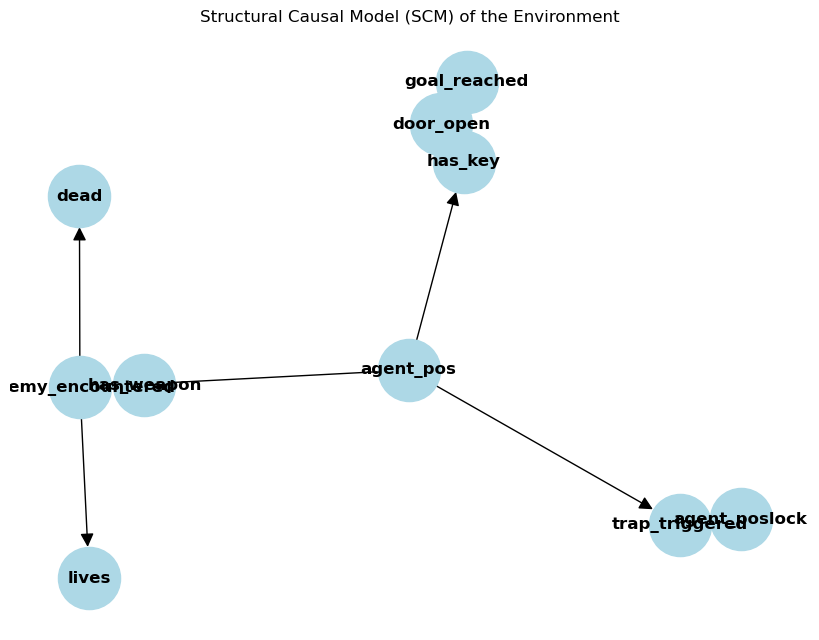

In [20]:
# Define the SCM as a directed graph
SCM = nx.DiGraph()
SCM.add_edges_from([
    ('agent_pos', 'has_key'),
    ('has_key', 'door_open'),
    ('agent_pos', 'enemy_encountered'),
    ('agent_pos', 'trap_triggered'),
    ('trap_triggered', 'agent_poslock'),
    ('enemy_encountered', 'lives'),
    ('has_weapon', 'enemy_encountered'),
    ('enemy_encountered', 'dead'),
    ('door_open', 'goal_reached')
])

# Draw the SCM
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(SCM)
nx.draw(SCM, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title('Structural Causal Model (SCM) of the Environment')
plt.show()


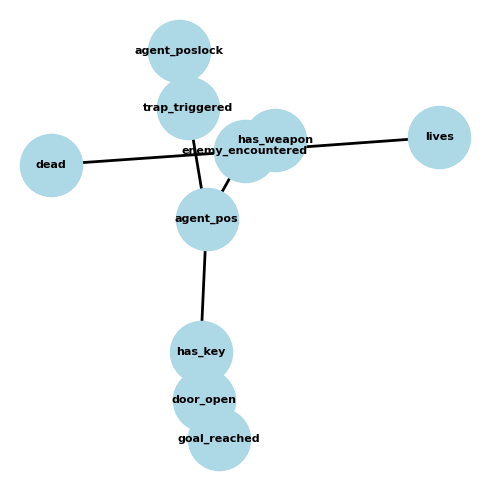

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the SCM as a directed graph
SCM = nx.DiGraph()
SCM.add_edges_from([
    ('agent_pos', 'has_key'),
    ('has_key', 'door_open'),
    ('agent_pos', 'enemy_encountered'),
    ('agent_pos', 'trap_triggered'),
    ('trap_triggered', 'agent_poslock'),
    ('enemy_encountered', 'lives'),
    ('has_weapon', 'enemy_encountered'),
    ('enemy_encountered', 'dead'),
    ('door_open', 'goal_reached')
])

# Specify positions (optional) for a cleaner layout
pos = nx.spring_layout(SCM, seed=20)

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw_networkx_nodes(SCM, pos, node_color='lightblue', node_size=2000)
nx.draw_networkx_edges(SCM, pos, arrows=True, arrowstyle='->', arrowsize=10, width=2)
nx.draw_networkx_labels(SCM, pos, font_size=8, font_weight='bold')

# You might annotate edges or nodes to clarify logic
# For example, we know that if 'has_weapon' → 'enemy_encountered', it affects survival.
# However, since this logic is more of a conditional than a direct single-edge effect,
# it may be better explained by adding textual annotations.

annotations = [
]

y_positions = [1.05, 1.00, 0.95]
for ann_text, y in zip(annotations, y_positions):
    plt.text(0.5, y, ann_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=15)

plt.title("", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
class MontezumaGridEnv(gym.Env):
    def __init__(self):
        super(MontezumaGridEnv, self).__init__()
        self.grid_size = (10, 10)
        self.action_space = spaces.Discrete(4)  # 0:Up, 1:Down, 2:Left, 3:Right
        self.observation_space = spaces.Dict({
            'agent_pos': spaces.MultiDiscrete([self.grid_size[0], self.grid_size[1]]),
            'has_key': spaces.Discrete(2),
            'door_open': spaces.Discrete(2),
            'goal_reached': spaces.Discrete(2),
            'enemy_encountered': spaces.Discrete(2),
            'trap_triggered': spaces.Discrete(2)
        })
        self.reset()
        
    def reset(self):
        self.agent_pos = [0, 0]  # Starting position
        self.has_key = False
        self.door_open = False
        self.goal_reached = False
        self.enemy_encountered = False
        self.trap_triggered = False
        self.done = False
        
        # Place objects in the grid
        self.key_pos = [2, 2]
        self.door_pos = [5, 5]
        self.goal_pos = [5, 6]
        self.enemies = [[3, 3], [7, 7]]
        self.traps = [[4, 4], [6, 6]]
        
        return self._get_obs()
    
    def step(self, action):
        if self.done:
            return self._get_obs(), 0, self.done, {}
        
        # Movement logic
        move = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        delta = move.get(action, (0, 0))
        new_pos = [self.agent_pos[0] + delta[0], self.agent_pos[1] + delta[1]]
        
        # Ensure the agent stays within bounds
        if 0 <= new_pos[0] < self.grid_size[0] and 0 <= new_pos[1] < self.grid_size[1]:
            self.agent_pos = new_pos
        
        # Update SCM variables based on agent's new position
        self._update_scm()
        
        # Check for terminal condition
        if self.goal_reached or self.enemy_encountered or self.trap_triggered:
            self.done = True
        
        reward = self._calculate_reward()
        return self._get_obs(), reward, self.done, {}
    
    def _update_scm(self):
        # agent_pos → has_key
        if self.agent_pos == self.key_pos:
            self.has_key = True
        
        # agent_pos → enemy_encountered
        if self.agent_pos in self.enemies:
            self.enemy_encountered = True
        
        # agent_pos → trap_triggered
        if self.agent_pos in self.traps:
            self.trap_triggered = True
        
        # has_key → door_open
        if self.has_key and self.agent_pos == self.door_pos:
            self.door_open = True
        
        # door_open → goal_reached
        if self.door_open and self.agent_pos == self.goal_pos:
            self.goal_reached = True
    
    def _calculate_reward(self):
        if self.goal_reached:
            return 100  # Reward for reaching the goal
        elif self.enemy_encountered or self.trap_triggered:
            return -100  # Penalty for encountering enemy or trap
        else:
            return -1  # Small penalty for each step to encourage efficiency
    
    def _get_obs(self):
        return {
            'agent_pos': np.array(self.agent_pos),
            'has_key': int(self.has_key),
            'door_open': int(self.door_open),
            'goal_reached': int(self.goal_reached),
            'enemy_encountered': int(self.enemy_encountered),
            'trap_triggered': int(self.trap_triggered)
        }
    
    def render(self, mode='human'):
        grid = [[' ' for _ in range(self.grid_size[1])] for _ in range(self.grid_size[0])]
        grid[self.agent_pos[0]][self.agent_pos[1]] = 'A'  # Agent
        grid[self.key_pos[0]][self.key_pos[1]] = 'K'      # Key
        grid[self.door_pos[0]][self.door_pos[1]] = 'D'    # Door
        grid[self.goal_pos[0]][self.goal_pos[1]] = 'G'    # Goal
        for enemy in self.enemies:
            grid[enemy[0]][enemy[1]] = 'E'                # Enemies
        for trap in self.traps:
            grid[trap[0]][trap[1]] = 'T'                  # Traps
        
        clear_output(wait=True)
        print('+' + '---+' * self.grid_size[1])
        for row in grid:
            print('|' + '|'.join(f' {cell} ' for cell in row) + '|')
            print('+' + '---+' * self.grid_size[1])


In [5]:
def intervene(env, variable, value):
    if variable == 'has_key':
        env.has_key = value
    elif variable == 'door_open':
        env.door_open = value
    elif variable == 'enemy_encountered':
        env.enemy_encountered = value
    elif variable == 'trap_triggered':
        env.trap_triggered = value
    elif variable == 'agent_pos':
        env.agent_pos = value
    elif variable == 'goal_reached':
        env.goal_reached = value


In [6]:
class CausalAgent:
    def __init__(self):
        # Initialize empty causal graph
        self.internal_causal_graph = nx.DiGraph()
        self.variables = ['agent_pos', 'has_key', 'door_open', 'goal_reached', 'enemy_encountered', 'trap_triggered']
        self.internal_causal_graph.add_nodes_from(self.variables)
        
    def update_causal_graph(self, data):
        # Placeholder for causal discovery algorithm
        # For simplicity, we'll assume the agent learns the true SCM over time
        # In practice, you would implement a causal discovery algorithm here
        pass
        
    def decide_action(self, observation):
        # Placeholder for decision-making logic
        # For simplicity, we'll perform random actions
        return np.random.choice([0, 1, 2, 3])
    
    def perform_intervention(self, env):
        # Decide whether to perform an intervention
        # For simplicity, we'll intervene randomly
        if np.random.rand() < 0.1:
            variable = np.random.choice(self.variables)
            value = np.random.choice([True, False]) if variable != 'agent_pos' else [np.random.randint(0, env.grid_size[0]), np.random.randint(0, env.grid_size[1])]
            intervene(env, variable, value)
            print(f'Intervened on {variable}, set to {value}')


In [7]:
# Initialize environment and agent
env = MontezumaGridEnv()
agent = CausalAgent()

num_episodes = 10
max_steps_per_episode = 100

for episode in range(num_episodes):
    observation = env.reset()
    print(f'\nEpisode {episode + 1}')
    
    for step in range(max_steps_per_episode):
        # ... (interaction code)
        # Collect data and update causal graph
        # ... (data collection and update)
        if done:
            env.render()
            if observation['goal_reached']:
                print('Goal Reached!')
            elif observation['enemy_encountered']:
                print('Encountered an Enemy!')
            elif observation['trap_triggered']:
                print('Triggered a Trap!')
            break
    
    # After each episode, update and visualize the internal causal graph
    agent.update_causal_graph()



Episode 1


NameError: name 'done' is not defined

In [8]:
!pip install pgmpy


In [9]:
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score
from pgmpy.models import BayesianNetwork


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [10]:
class CausalAgent:
    def __init__(self):
        # Initialize empty causal graph
        self.internal_causal_graph = nx.DiGraph()
        self.variables = ['agent_pos_x', 'agent_pos_y', 'has_key', 'door_open', 'goal_reached', 'enemy_encountered', 'trap_triggered']
        self.internal_causal_graph.add_nodes_from(self.variables)

        # Data storage for causal discovery
        self.data = []

    def update_causal_graph(self):
        if len(self.data) < 100:  # Wait until we have enough data
            return

        # Convert data to a DataFrame
        import pandas as pd
        df = pd.DataFrame(self.data)

        # Use Hill Climb Search with BicScore
        hc = HillClimbSearch(df)
        best_model = hc.estimate(scoring_method=BicScore(df))

        # Update the internal causal graph
        self.internal_causal_graph = nx.DiGraph()
        self.internal_causal_graph.add_nodes_from(best_model.nodes())
        self.internal_causal_graph.add_edges_from(best_model.edges())

        # Visualize the learned causal graph
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.internal_causal_graph)
        nx.draw(self.internal_causal_graph, pos, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10, font_weight='bold', arrowsize=20)
        plt.title('Agent\'s Internal Causal Graph')
        plt.show()

    def decide_action(self, observation):
        # Placeholder for decision-making logic
        # For simplicity, we'll perform random actions
        return np.random.choice([0, 1, 2, 3])

    def perform_intervention(self, env):
        # Decide whether to perform an intervention
        # For simplicity, we'll intervene randomly
        if np.random.rand() < 0.05:
            variable = np.random.choice(['has_key', 'door_open'])
            value = np.random.choice([True, False])
            intervene(env, variable, value)
            print(f'Intervened on {variable}, set to {value}')


In [32]:
# Initialize environment and agent
env = MontezumaGridEnv()
agent = CausalAgent()

num_episodes = 100
max_steps_per_episode = 1000000

for episode in range(num_episodes):
    observation = env.reset()
    print(f'\nEpisode {episode + 1}')
    
    for step in range(max_steps_per_episode):
        env.render()
        # Agent decides on an action
        action = agent.decide_action(observation)
        
        # Agent may perform an intervention
        agent.perform_intervention(env)
        
        # Take a step in the environment
        observation, reward, done, info = env.step(action)
        
        # Collect data for causal discovery
        obs = observation.copy()
        obs_flat = {
            'agent_pos_x': obs['agent_pos'][0],
            'agent_pos_y': obs['agent_pos'][1],
            'has_key': obs['has_key'],
            'door_open': obs['door_open'],
            'goal_reached': obs['goal_reached'],
            'enemy_encountered': obs['enemy_encountered'],
            'trap_triggered': obs['trap_triggered']
        }
        agent.data.append(obs_flat)
        
        # Periodically update the internal causal graph
        if step % 10 == 0:
            agent.update_causal_graph()
        
        if done:
            env.render()
            if observation['goal_reached']:
                print('Goal Reached!')
            elif observation['enemy_encountered']:
                print('Encountered an Enemy!')
            elif observation['trap_triggered']:
                print('Triggered a Trap!')
            break


+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   | K |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   | E |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   | T |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   | D | G |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   | T |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   | E |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+
Encountered an Enemy!
